In [144]:
from __future__ import print_function, division
from builtins import range
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd

In [145]:
# Error Rate between Targets and predictions
def error_rate(p, t):
    return np.mean(p != t)

#Turns an N*1 Vector of targets into a indicator matrix
def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [146]:
def get_normalized_data():
    print("Reading in and transforming data...")

    if not os.path.exists('Mnist/train.csv'):
        print('Looking for Mnist/train.csv')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: https://www.kaggle.com/c/digit-recognizer')
        print('Place train.csv in the folder large_files adjacent to the class folder')
        exit()

    df = pd.read_csv('Mnist/train.csv')
    data = df.values.astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = data[:, 0]

    Xtrain = X[:-1000]
    Ytrain = Y[:-1000]
    Xtest  = X[-1000:]
    Ytest  = Y[-1000:]

    # normalize the data
    mu = Xtrain.mean(axis=0)
    std = Xtrain.std(axis=0)
    np.place(std, std == 0, 1)
    Xtrain = (Xtrain - mu) / std
    Xtest = (Xtest - mu) / std
    
    return Xtrain, Xtest, Ytrain, Ytest

In [147]:
Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()

Reading in and transforming data...


In [148]:
max_iter = 15
print_period = 50
lr = 0.00004
reg = 0.01
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)
N, D = Xtrain.shape
batch_sz = 500
n_batches = N//batch_sz
M1 = 300
M2 = 100
K = 10
W1_init = np.random.randn(D, M1) / 28
b1_init = np.zeros(M1)
W2_init = np.random.randn(M1, M2) / np.sqrt(M1)
b2_init = np.zeros(M2)
W3_init = np.random.randn(M2, K) / np.sqrt(M2)
b3_init = np.zeros(K)

In [149]:
X = tf.placeholder(tf.float32, shape = (None, D), name ='X')
T = tf.placeholder(tf.float32, shape = (None, K), name = 'T')
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
Z1 = tf.nn.relu(tf.matmul(X,W1) + b1)
Z2 = tf.nn.relu(tf.matmul(Z1,W2) + b2)
NotY = tf.matmul(Z2,W3) + b3
cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=NotY, labels=T))

In [150]:
train_op = tf.train.RMSPropOptimizer(lr, decay=0.99, momentum=0.9).minimize(cost)
predict_op = tf.argmax(NotY, 1)

In [151]:
LL =[]
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    
    
    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
            if j % print_period == 0:
                test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest_ind})
                prediction = session.run(predict_op, feed_dict={X: Xtest})
                err = error_rate(prediction, Ytest)
                print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                LL.append(test_cost)

Cost / err at iteration i=0, j=0: 2378.800 / 0.882
Cost / err at iteration i=0, j=50: 378.538 / 0.103
Cost / err at iteration i=1, j=0: 282.758 / 0.080
Cost / err at iteration i=1, j=50: 223.292 / 0.063
Cost / err at iteration i=2, j=0: 198.585 / 0.053
Cost / err at iteration i=2, j=50: 174.531 / 0.049
Cost / err at iteration i=3, j=0: 163.354 / 0.044
Cost / err at iteration i=3, j=50: 148.759 / 0.040
Cost / err at iteration i=4, j=0: 143.601 / 0.038
Cost / err at iteration i=4, j=50: 132.798 / 0.038
Cost / err at iteration i=5, j=0: 130.869 / 0.033
Cost / err at iteration i=5, j=50: 122.716 / 0.037
Cost / err at iteration i=6, j=0: 122.845 / 0.033
Cost / err at iteration i=6, j=50: 116.685 / 0.034
Cost / err at iteration i=7, j=0: 117.874 / 0.032
Cost / err at iteration i=7, j=50: 112.793 / 0.032
Cost / err at iteration i=8, j=0: 114.814 / 0.033
Cost / err at iteration i=8, j=50: 111.217 / 0.030
Cost / err at iteration i=9, j=0: 113.840 / 0.032
Cost / err at iteration i=9, j=50: 110.6

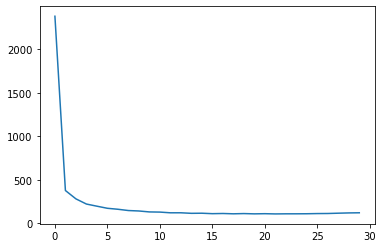

In [152]:
plt.plot(LL)
plt.show()